# Example of MCMC run

In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
import HDF5
using BenchmarkTools

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using DSP

In [3]:
# using Revise
using Random123
using BAT 

┌ Warning: Error requiring `HDF5` from `BAT`
│   exception = (LoadError("/user/.julia/packages/BAT/PLQc0/src/io/hdf5_specific.jl", 4, UndefVarError(:DataFile)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f1d7cb5e73f, Ptr{Nothing} @0x00007f1d7cbf0944, Ptr{Nothing} @0x00007f1d6e189ef2, Ptr{Nothing} @0x00007f1d7cbd62f2, Ptr{Nothing} @0x00007f1d7cbef5f5, Ptr{Nothing} @0x00007f1d7cbef23f, Ptr{Nothing} @0x00007f1d7cbefc43, Ptr{Nothing} @0x00007f1d7cbf0ea7, Base.InterpreterIP in top-level CodeInfo for BAT at statement 3, Ptr{Nothing} @0x00007f1d7cc0e129, Ptr{Nothing} @0x00007f1d7cbe0905, Ptr{Nothing} @0x00007f1d7cc0f6d1, Ptr{Nothing} @0x00007f1d6e6854ed, Ptr{Nothing} @0x00007f1d02e779ce, Ptr{Nothing} @0x00007f1d7cbd5e27, Ptr{Nothing} @0x00007f1d7cbef5f5, Ptr{Nothing} @0x00007f1d7cbef23f, Ptr{Nothing} @0x00007f1d7cbefc43, Ptr{Nothing} @0x00007f1d7cbf0ea7, Base.InterpreterIP in top-level CodeInfo for BAT at statement 12, Ptr{Nothing} @0x00007f1d7cc0e129, Ptr{Nothing} @0x00007f

# Load Data

In [4]:
function trunc_norm(m, sgm; alpha=2)
    return truncated(Normal(m, sgm), m - alpha*sgm, m + alpha*sgm)
end

trunc_norm (generic function with 1 method)

## 1.1 Low `p` Population: 

In [ ]:
# conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2")

# conv_matrices = (
#     cam_1 = conv_mat["cam_1"],
#     cam_2 = conv_mat["cam_2"],
#     cam_3 = conv_mat["cam_3"],
#     cam_4 = conv_mat["cam_4"], 
# )

# images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
# event_number = 343

# # Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

# event = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_4"][event_number,:,:],
#     population = images["charge"][event_number,:][1],
# );

## 1.2 High `p` Population: 

In [5]:
conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../data/experiment/dataset_2/m2/images-satur.jld2"); # removed saturated pixels
# images = load("../data/experiment/dataset_2/m2/images.jld2"); # included saturated pixels
event_number = 2

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


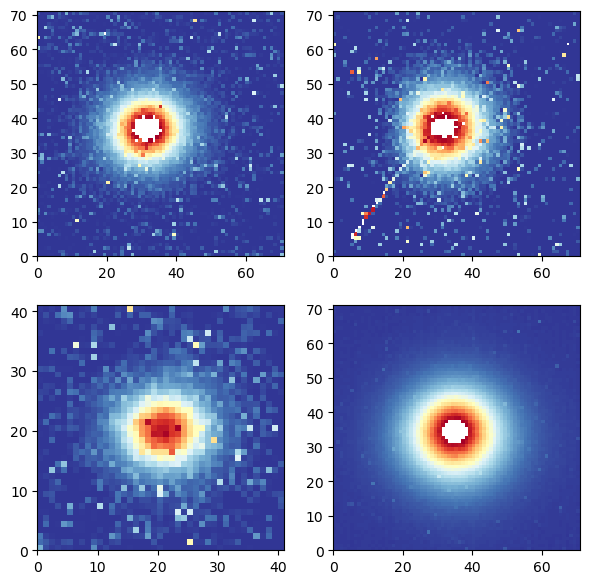

PyObject <matplotlib.collections.QuadMesh object at 0x7f1cf6821c70>

In [6]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

# Load Model

## Model 35: 

In [7]:
include("../src/model-35/likelihood.jl")
include("../src/model-35/utill_model.jl")
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [8]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

prior = NamedTupleDist(
    tr_size = [truncated(Normal(0.2, 0.04), 0.05, 0.20), truncated(Normal(0.2, 0.04), 0.05, 0.20)],
    ang_spr = [truncated(Normal(4.0, 2.0), 3.0, 6.0), truncated(Normal(4.0, 2.0), 3.0, 6.0)],
    waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
    algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    cam4_ped = 4.0 .. 40.0,
    cam4_light_fluct = 1.0 .. 3.0,
    cam4_light_amp = 1.6 .. 9.9, 
    resx = [1.0, 1.0, 1.0], 
    resy = [1.0, 1.0, 1.0], 
    cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
    cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
    psx = [27.1, 21.6, 114.0], # 31, 32, 33
    psy = [30.5, 23.4, 125.0], # 34, 35, 36
    cam4_psx = 121.8, # 37
    cam4_psy = 120.0, # 38
    light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
    s_cam = [0.0, 1.478, 15.026, 23.1150],
); 


## Model 38: 

In [ ]:
# include("../src/model-38/likelihood.jl")
# include("../src/model-38/utill_model.jl")
# include("../src/utill.jl")

In [ ]:
# β1= 0.015
# β2 = 0.0077
# β3 = 0.0058 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 23, 24, 25, 
#     resy = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 26,27, 28, 
#     cam4_resx = trunc_norm(3, 1.5), # 29, 
#     cam4_resy = trunc_norm(3, 1.5), # 30
#     psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
#     psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
#     cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
#     cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.20), truncated(Normal(0.2, 0.04), 0.06, 0.20)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 2.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [1, 1, 1], # 23, 24, 25, 
#     resy = [1, 1, 1], # 26,27, 28, 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
#     psx = [27.1, 21.6, 114.0], # 31, 32, 33
#     psy = [30.5, 23.4, 125.0], # 34, 35, 36
#     cam4_psx = 121.8, # 37
#     cam4_psy = 120.0, # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

## Model 41: 

In [ ]:
# include("../src/model-41/likelihood.jl")
# include("../src/model-41/utill_model.jl")
# include("../src/utill.jl")

In [ ]:
# β1= 0.015
# β2 = 0.0077
# β3 = 0.0058 

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.16), truncated(Normal(0.2, 0.04), 0.03, 0.16)],
#         tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.16), truncated(Normal(0.2, 0.04), 0.03, 0.16)],
#         ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#         ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
#         mixt_pow =  0.30 .. 1.0 ,
#         waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
#         waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
#         algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         cam4_ped = 4.0 .. 40.0,
#         cam4_light_fluct =  1.0 .. 3.0,
#         cam4_light_amp = 1.6 .. 9.9, 
#         resx = [1, 1, 1], # 23, 24, 25, 
#         resy = [1, 1, 1], # 26,27, 28, 
#         cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#         cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
#         psx = [27.1, 21.6, 114.0], # 31, 32, 33
#         psy = [30.5, 23.4, 125.0], # 34, 35, 36
#         cam4_psx = 121.8, # 37
#         cam4_psy = 120.0, # 38
#         light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     );



# MCMC settings: 

In [9]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_discrete,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

function log_lik_diff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_cont,
    cv_1 = exp.(cv_mat.cam_1),
    cv_2 = exp.(cv_mat.cam_2),
    cv_3 = exp.(cv_mat.cam_3),
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        
        return LogDVal(ll)
    end
    
end

# log_likelihood = log_lik_diff()

log_likelihood = log_lik_ndiff()

#50 (generic function with 1 method)

In [10]:
# posterior = PosteriorDensity(log_likelihood, prior)

# tuning = AdaptiveMHTuning(
#     λ = 0.5,
#     α = ClosedInterval(0.15,0.25),
#     β = 1.5,
#     c = ClosedInterval(1e-4,1e2),
#     r = 0.5,
# )

# convergence = BrooksGelmanConvergence(
#     threshold = 1.1,
#     corrected = false
# )

# init = MCMCChainPoolInit(
#     init_tries_per_chain = ClosedInterval(50,150),
#     max_nsamples_init = 500,
#     max_nsteps_init = 500,
#     max_time_init = Inf
# )

# burnin = MCMCMultiCycleBurnin(
#     max_nsamples_per_cycle = 10000,
#     max_nsteps_per_cycle = 10000,
#     max_time_per_cycle = Inf,
#     max_ncycles = 130
# )

# nsamples = 1*10^5
# nchains = 4

# sampler = MetropolisHastings(tuning=tuning,)

# algorithm = MCMCSampling(sampler=sampler, 
#     nchains=nchains, 
#     init=init, 
#     burnin=burnin, 
#     convergence=convergence
# );

In [11]:
# log_likelihood(param_truth)
# @benchmark log_likelihood(param_truth)

In [12]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

mcmcalgo = MetropolisHastings(
    weighting = RepetitionWeighting(),
    tuning = tuning
)

rng = Philox4x()

init = MCMCChainPoolInit(
    init_tries_per_chain = 50 .. 150,
    nsteps_init = 1000
)

burnin = MCMCMultiCycleBurnin(
    max_ncycles = 100,
    nsteps_per_cycle = 10000
)

nsamples = 1*10^5
nchains = 4

convergence = BrooksGelmanConvergence();

In [13]:
@time samples_tot = bat_sample(
    rng, posterior,
    MCMCSampling(
        sampler = mcmcalgo,
        nchains = nchains,
        nsteps = nsamples,
        init = init,
        burnin = burnin,
        convergence = convergence,
#         strict = false,
#         store_burnin = false,
#         nonzero_weights = true,
    )
);

┌ Info: Using tranform algorithm PriorSubstitution()
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/chain_pool_init.jl:48
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/chain_pool_init.jl:166
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/multi_cycle_burnin.jl:27
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/multi_cycle_burnin.jl:57
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/multi_cycle_burnin.jl:57
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/PLQc0/src/samplers/mcmc/multi_cycle_burnin.jl:57
┌ Info: MCMC Tuning cycle 4 finished, 4 chains

1481.510126 seconds (2.34 G allocations: 2.015 TiB, 8.57% gc time)


In [14]:
samples = samples_tot.result;

In [15]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

2.9413394573239837

In [16]:
size(flatview(unshaped.(samples.v)))

(21, 66727)

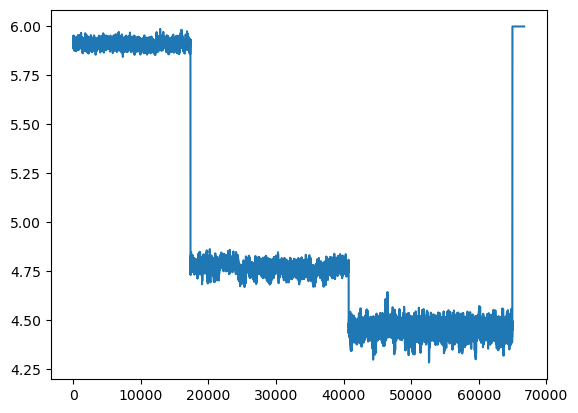

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1cf7151ca0>

In [17]:
plot(flatview(unshaped.(samples.v))[3,:])

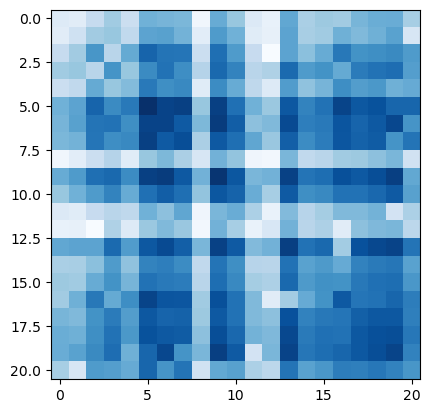

PyObject <matplotlib.image.AxesImage object at 0x7f1cf7127fd0>

In [18]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [ ]:
# BAT.bat_write("../data/sampling_results/Tmp-Mixture-Model-38-2/mm-38-hc-2-fixed-lf.hdf5", unshaped.(samples))

# BAT.bat_write("../data/sampling_results/Benchmark-8/samples-41.hdf5", unshaped.(samples))

In [ ]:
#  27.1, 21.6, 114.0, 30.5, 23.4, 125.0, 121.8, 120.0

In [ ]:
mode(samples)[1]

In [ ]:
bat_marginalmode(samples).result

In [ ]:
mean(samples)[1]

In [ ]:
std(samples)[1]

In [ ]:
dims = [1,2,3,4,5,6,7,8,9,10,11]
# dims = [1,2,3,4,5,]
names = [1,2,3,4,5,6,7,8,9,10, 11]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [10,11,]
names = [10,11,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.1,  1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
params_array = [mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [ ]:
images = load("../data/experiment/dataset_2/m1/images.jld2")
event_ns = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

In [ ]:
plot_projections(conv_matrices, event_ns, event, params_array[1], isnontr = true)

In [ ]:
# try model 38 with light fluctuations constant on the IS2
# fixe resolution in the IS2 amera